In [ ]:
!pip install segmentation-models-pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm

import sys, os, random, time
import numba, cv2, gc
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

from segmentation_models_pytorch.unetplusplus import UnetPlusPlus
from segmentation_models_pytorch.unet import Unet
import segmentation_models_pytorch as smp

import rasterio
from rasterio.windows import Window

import albumentations as A

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold

%matplotlib inline

In [3]:
def set_seeds(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seeds()

### Setup training variables

In [4]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [5]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [6]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [7]:
# Check run length encoding starting with 0
assert rle_numba([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [2, 2, 5, 1, 7, 4, 12, 1]
# Check run length encoding starting with 0
assert rle_numba([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1]) == [1, 3, 5, 1, 7, 4, 12, 1]

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels' of function 'rle_numba'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-313ecb27751d>", line 2:
@numba.njit()
def rle_numba(pixels):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [8]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [9]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
54f2eec69  124601765 36 124632133 109 124662536 147 12469...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [10]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

import shutil

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [11]:
WINDOW = 1024 # tile size
MIN_OVERLAP = 32
NEW_SIZE = 512 # size after re-size which are fed to the model
THRESHOLD = 0

In [12]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = 0.08, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [13]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, window=256, overlap=32, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.threshold = overlap, window, transform, threshold
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = MASK_PATH/f'slices.pkl'
        files_path = MASK_PATH/f'files.pkl'
        masks_path = MASK_PATH/f'masks.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            with open(masks_path, "wb") as filehandler:
                pickle.dump(self.masks, filehandler)
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
            with open(masks_path,'rb') as file:
                self.masks = pickle.load(file)
                        
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
#         slices_copy = slices.copy()
#         slices_copy_y = slices.copy()
        # horizontal
#         slices_copy[:,(0,1)] += WINDOW // 2 # shift
#         slices = np.concatenate ([slices, slices_copy])
        # vertical
#         slices_copy_y[:,(2,3)] += WINDOW // 2
#         slices = np.concatenate ([slices, slices_copy_y])
#         slices = slices[~(slices[:,1] > dataset.shape[0]),:] # filter those outside of the screen
#         slices = slices[~(slices[:,3] > dataset.shape[1]),:] # filter those outside of the screen

        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, x1, x2 , y1, y2)
            contains_info = is_tile_contains_info(image)
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, mask
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped}'

In [14]:
reset_mask_path()
!mkdir {MASK_PATH}

In [15]:
def generate_ds(size):
    trfm = A.Compose([
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter (brightness=0.07, contrast=0.07,
                       saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
                A.RandomBrightness(p=1)
            ],
            p=0.5,
        )
    ])

    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)

ds = generate_ds(NEW_SIZE)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [16]:
ds

total: 1776, skipped: 5730

(1024, 1024, 3)


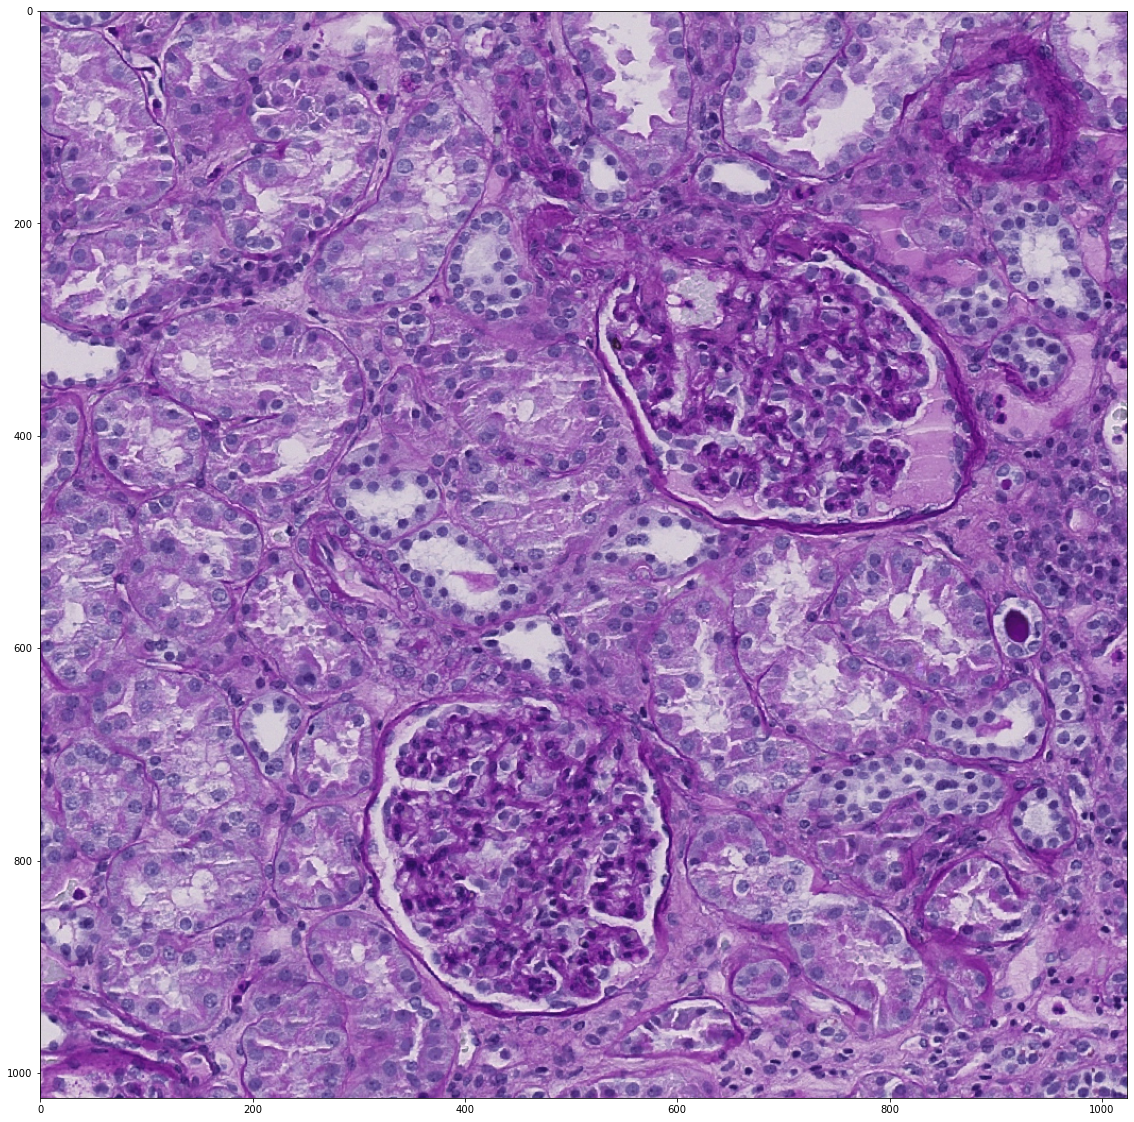

In [17]:
with rasterio.open('/home/jupyter/data/train/2f6ecfcdf.tiff') as raster:
    img = raster.read([1,2,3], window=Window.from_slices((3909, 4933),(11464,12488)))
    img = np.moveaxis(img, 0, -1)
    print(img.shape)
    crs = raster.crs

plt.figure(figsize = (20,20))
plt.imshow(img)
plt.show()


Writing to /home/jupyter/ds_cache/image_0


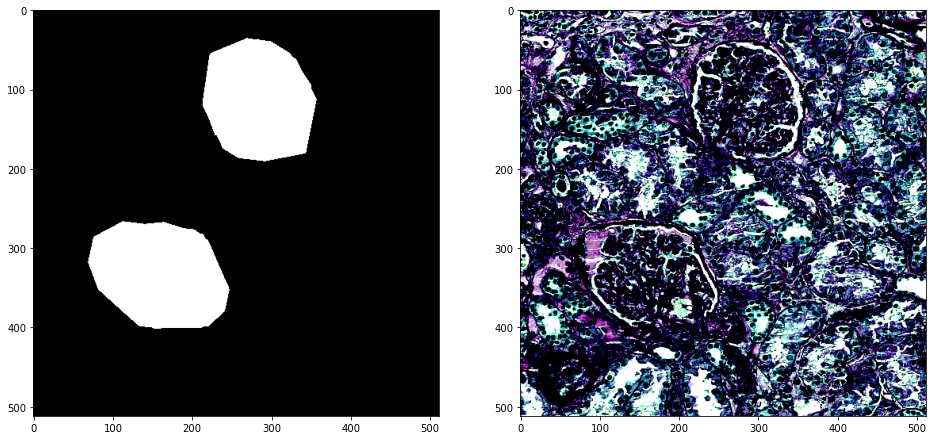

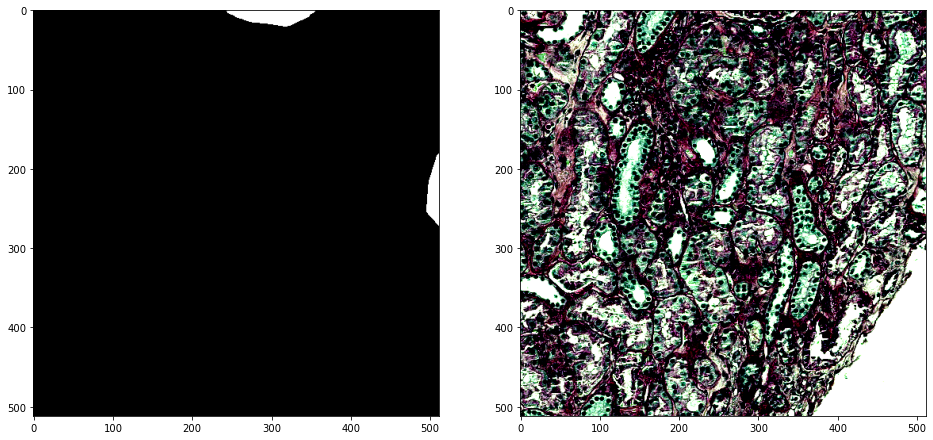

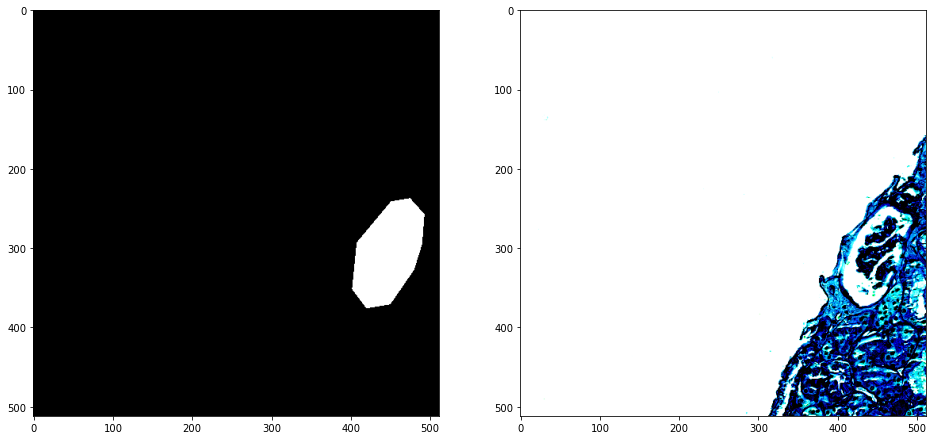

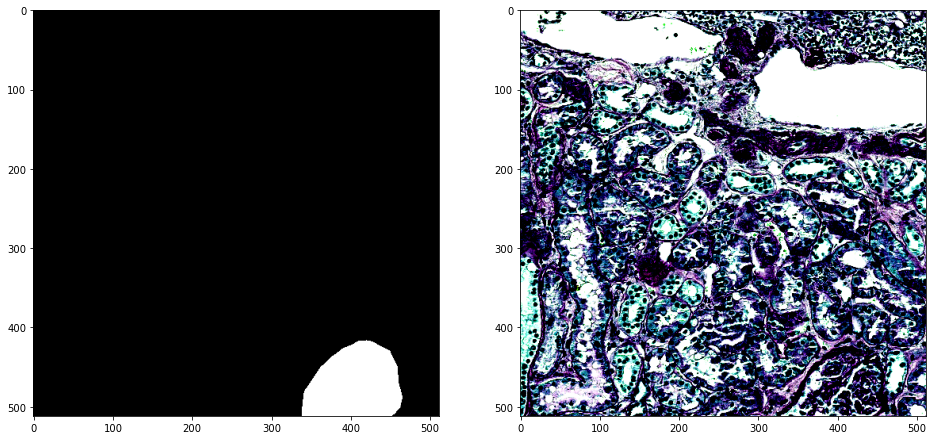

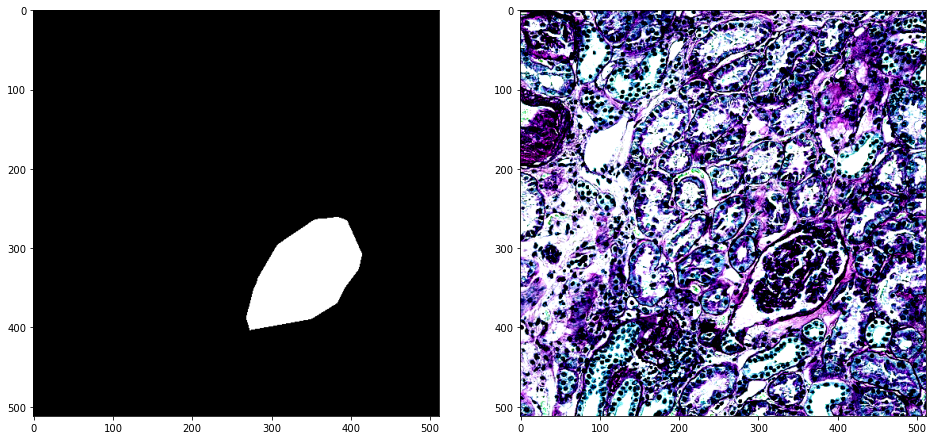

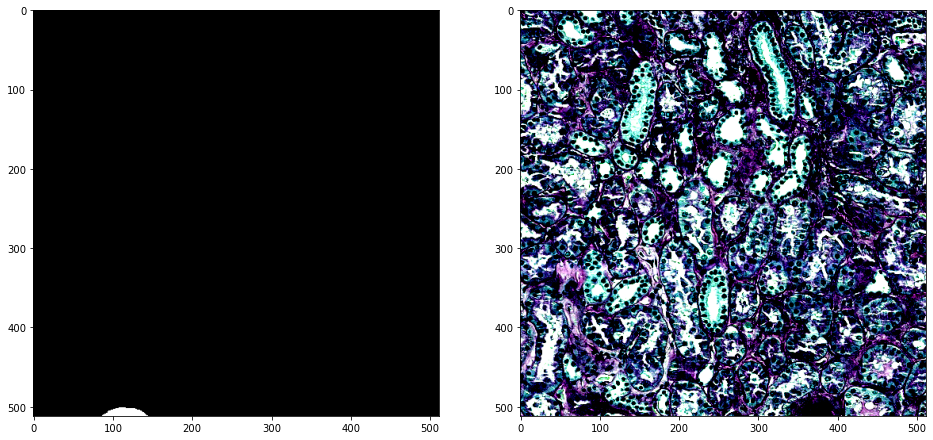

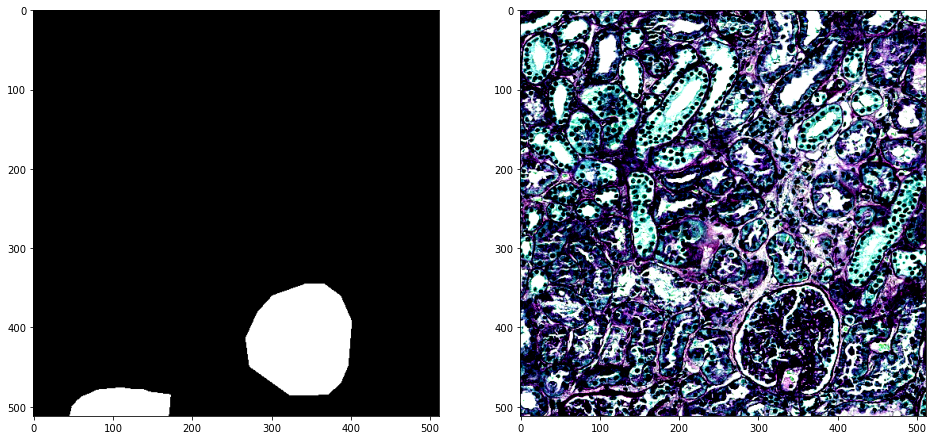

In [18]:
def display_mask_img(idx):
    image, mask = ds[idx]
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

display_mask_img(2)
display_mask_img(1)
display_mask_img(0)
display_mask_img(3)
display_mask_img(5)
display_mask_img(6)
display_mask_img(7)

In [19]:
image, mask = ds[0]

_ = rle_numba_encode(mask[0]) # compile function with numba

#### Split

In [20]:
FOLDS = 2

In [21]:
# Images and its corresponding masks are saved with the same filename.
groups = [ds.slices[i][0] for i in range(len(ds))]

In [22]:
# ds.slices

In [23]:
group_kfold = GroupKFold(n_splits = FOLDS)

In [24]:
def create_split_on_index(img_index = 7):
    valid_idx, train_idx = [], []
    for i in range(len(ds)):
        if ds.slices[i][0] == img_index:
            valid_idx.append(i)
        else:
            train_idx.append(i)
    return valid_idx, train_idx

#### Data loaders

In [25]:
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    valid_ds = D.Subset(ds, valid_idx)

    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    return train_dl, valid_dl

### Model

In [27]:
ENCODER_NAME = 'efficientnet-b6'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = Unet(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        img_masks = self.model(images)
        return img_masks

In [28]:
def get_model():
    model = HuBMAPModel()
    return model

### Training

In [29]:
LR = 1e-3
WD = 1e-3
BEST_MODEL = f'best_model_unet_1024_double_shift_grad_acc_{ENCODER_NAME}.pth'

In [30]:
def create_optimizer_scheduler(model, train_dl, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                    steps_per_epoch=len(train_dl), epochs=epochs)
    return optimizer, scheduler

### Loss

In [31]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def mixed_bce_dice_loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.5 * bce + 0.5 * dice

In [32]:
dice_loss = smp.utils.losses.DiceLoss()

def dice_loss_fn(y_pred, y_true):
    return dice_loss(y_pred.sigmoid(), y_true)

In [33]:
jaccard_loss = smp.utils.losses.JaccardLoss()

def jaccard_loss_fn(y_pred, y_true):
    return jaccard_loss(y_pred.sigmoid(), y_true)

In [34]:
def dice_metric(y_pred, y, epsilon = 1.0):
    dims=(-2,-1)
    x = (y_pred > 0).float()
    dc = (2 * (x * y).sum(dims) + epsilon) / ((x + y).sum(dims) + epsilon)
    return dc.mean()

In [35]:
iou_metric = smp.utils.metrics.IoU(threshold=0.5)

In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_epoch(model, dataloader, optim, scheduler, optuna_params, device="cpu", grad_accu_steps=4):
    model.train()
    
    train_loss = []
    labels = []
    outs = []
    lrs = []
    
    tbar = tqdm(dataloader)
    scaler = torch.cuda.amp.GradScaler() # mixed precision support
    scale = None
    
    criterion = optuna_params["losses"]
    
    for step, (image, target) in enumerate(tbar):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        
        with torch.cuda.amp.autocast():
            output = model(image)
            loss = criterion(output, target) / grad_accu_steps
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step + 1) % grad_accu_steps == 0:
            scaler.step(optim)
            scale = scaler.get_scale()
            scaler.update()
            optim.zero_grad()
        
        skip_lr_sched = (scale != scaler.get_scale())
        if not skip_lr_sched:
            scheduler.step()
        
        loss_val = loss.item() * grad_accu_steps
        train_loss.append(loss_val)
        lrs.append(get_lr(optim))
        
        tbar.set_description('loss - {:.4f}'.format(loss_val))
        
    print(f'Train loss: {np.array(train_loss).mean()}')
    return train_loss, lrs

In [37]:
def val_epoch(model, dataloader, epoch, optuna_params, device="cpu"):
    model.eval()

    valid_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    dice_metrics = []
    iou_metrics = []
    
    criterion = optuna_params["losses"]

    for item in dataloader:
        image, target = item
        image, target = image.to(DEVICE), target.float().to(DEVICE)

        with torch.no_grad():
            output = model(image)
            loss = criterion(output, target)
            dice_metrics.append(dice_metric(output, target))
            iou_metrics.append(iou_metric(output, target))
        valid_loss.append(loss.item())

    avg_loss = np.array(valid_loss).mean()
    print(f'Epoch {epoch} - valid loss: {avg_loss}')
    dice_metrics = [x.item() for x in dice_metrics]
    iou_metrics = [x.item() for x in iou_metrics]
    dice_metric_mean = np.array(dice_metrics).mean()
    iou_metric_mean = np.array(iou_metrics).mean()
    return dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean

In [38]:
def train(epochs, train_dl, valid_dl, optimizer, scheduler, optuna_params, patience = 6):
    best_loss = 100.0
    best_metric = 0
    train_losses = []
    valid_losses = []
    accumulated_lrs = []
    accumulated_dice_metrics = []
    early_stop_counter = 0

    for epoch in tqdm(range(epochs)):
        train_loss, lrs = train_epoch(model, train_dl, optimizer, scheduler, optuna_params, DEVICE, grad_accu_steps=4)
        dice_metrics, valid_loss, dice_metric_mean, avg_loss, iou_metric_mean = val_epoch(model, valid_dl, epoch, optuna_params, DEVICE)
        train_losses += train_loss
        valid_losses.append(np.array(valid_loss).mean())
        accumulated_lrs += lrs
        accumulated_dice_metrics.append(np.array(dice_metrics).mean())
        if best_metric < iou_metric_mean:
            best_metric = iou_metric_mean
            print('Saving model')
            torch.save(model.state_dict(), BEST_MODEL)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if best_loss > avg_loss:
            best_loss = avg_loss
        print(f'Epoch {epoch} - val best loss {best_loss} dice metric ({dice_metric_mean}) iou metric ({iou_metric_mean}).')
        if early_stop_counter >= patience:
            print('Stopping early')
            break
        
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [39]:
# reset_mask_path()
# !mkdir {MASK_PATH}

In [40]:
EPOCHS = 4
PATIENCE = 5

In [41]:
def train_split(fold_info, fold, optuna_params):
    global model
    
    print(f'Processing fold {fold}')
    model = get_model()
    model.to(DEVICE)
    train_idx, valid_idx = fold_info[fold]
    f'Proportions valid / train: {len(valid_idx) / len(train_idx)}'
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
    optimizer, scheduler = create_optimizer_scheduler(model, train_dl, EPOCHS)
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train(EPOCHS, train_dl, valid_dl, optimizer, scheduler, optuna_params, patience = PATIENCE)
    return train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics

In [42]:
fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                        groups = groups)), total=FOLDS)]

  0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
train_idx, valid_idx = fold_info[0]
train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)
for image, target in tqdm(train_dl):
    pass
#     assert image.shape[0] > 1
for image, target in tqdm(valid_dl):
    pass
#     assert image.shape[0] > 1

  0%|          | 0/111 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Writing to /home/jupyter/ds_cache/image_1600
Writing to /home/jupyter/ds_cache/image_400
Writing to /home/jupyter/ds_cache/image_1500
Writing to /home/jupyter/ds_cache/image_600
Writing to /home/jupyter/ds_cache/image_1400
Writing to /home/jupyter/ds_cache/image_1700
Writing to /home/jupyter/ds_cache/image_500
Writing to /home/jupyter/ds_cache/image_300


  0%|          | 0/112 [00:00<?, ?it/s]

Writing to /home/jupyter/ds_cache/image_100
Writing to /home/jupyter/ds_cache/image_200
Writing to /home/jupyter/ds_cache/image_700
Writing to /home/jupyter/ds_cache/image_800
Writing to /home/jupyter/ds_cache/image_900
Writing to /home/jupyter/ds_cache/image_1000
Writing to /home/jupyter/ds_cache/image_1100
Writing to /home/jupyter/ds_cache/image_1200
Writing to /home/jupyter/ds_cache/image_1300


In [44]:
def train_split_and_move(fold_info, fold, optuna_params):
    train_losses, valid_losses, accumulated_lrs, accumulated_dice_metrics = train_split(fold_info, fold, optuna_params)
    !mv {BEST_MODEL} {fold}_{BEST_MODEL}
    stats_df = pd.DataFrame({'train_losses': train_losses, 'accumulated_lrs': accumulated_lrs})
    stats_df[['train_losses']].plot()
    val_stats_df = pd.DataFrame({'valid_losses': valid_losses})
    val_stats_df[['valid_losses']].plot()
    return valid_losses

In [45]:
import optuna

def objective(trial):
    optuna_params = {
        "losses": trial.suggest_categorical("loss", [mixed_bce_dice_loss_fn, dice_loss_fn, jaccard_loss_fn])
    }
    all_losses = []
    for fold in range(FOLDS):
        valid_losses = train_split_and_move(fold_info, fold, optuna_params)
        all_losses.append(np.mean(valid_losses))
    return np.mean(all_losses)

[I 2021-02-18 10:37:55,044] A new study created in memory with name: no-name-4ec35219-89d9-4fd7-bc48-ed7f6a13d260
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function mixed_bce_dice_loss_fn at 0x7f0393fb79e0> which is of type function.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function dice_loss_fn at 0x7f027911ce60> which is of type function.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function jaccard_loss_fn at 0x7f034ed0eef0> which is of type fu

Processing fold 0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.90169880143157
Epoch 0 - valid loss: 0.8764833488634655
Saving model
Epoch 0 - val best loss 0.8764833488634655 dice metric (0.2280040741232889) iou metric (0.14900618415725017).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.741600151534553
Epoch 1 - valid loss: 0.6340368326221194
Saving model
Epoch 1 - val best loss 0.6340368326221194 dice metric (0.5924943262445075) iou metric (0.5139442565185683).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.443112326097918
Epoch 2 - valid loss: 0.4234506083386285
Saving model
Epoch 2 - val best loss 0.4234506083386285 dice metric (0.6912639425801379) iou metric (0.6601511064384665).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.34319966977781
Epoch 3 - valid loss: 0.38246204384735655
Saving model
Epoch 3 - val best loss 0.38246204384735655 dice metric (0.7083423494228295) iou metric (0.6953955532184669).
Processing fold 1


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.9068644738623074
Epoch 0 - valid loss: 0.8807401737651309
Saving model
Epoch 0 - val best loss 0.8807401737651309 dice metric (0.23285427676127837) iou metric (0.1540808976703399).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.769017366958516
Epoch 1 - valid loss: 0.5934918087881964
Saving model
Epoch 1 - val best loss 0.5934918087881964 dice metric (0.6756944165036485) iou metric (0.6310770798910845).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.5103615676718098
Epoch 2 - valid loss: 0.40160281754828786
Saving model
Epoch 2 - val best loss 0.40160281754828786 dice metric (0.7345614825283084) iou metric (0.7191423843572805).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.40792507997580935
Epoch 3 - valid loss: 0.38838483567710397
Saving model
Epoch 3 - val best loss 0.38838483567710397 dice metric (0.7366894207022212) iou metric (0.7212620484936345).


[I 2021-02-18 11:01:40,054] Trial 0 finished with value: 0.5725815586812861 and parameters: {'loss': <function jaccard_loss_fn at 0x7f034ed0eef0>}. Best is trial 0 with value: 0.5725815586812861.


Processing fold 0


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function mixed_bce_dice_loss_fn at 0x7f0393fb79e0> which is of type function.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function dice_loss_fn at 0x7f027911ce60> which is of type function.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function jaccard_loss_fn at 0x7f034ed0eef0> which is of type function.
  warnings.warn(message)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 1.03414037850526
Epoch 0 - valid loss: 0.9623371000800814
Saving model
Epoch 0 - val best loss 0.9623371000800814 dice metric (0.15213857205318554) iou metric (0.11688241914712957).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.7108343920192203
Epoch 1 - valid loss: 0.6037153819841998
Saving model
Epoch 1 - val best loss 0.6037153819841998 dice metric (0.3988935642742685) iou metric (0.29259414804567185).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.490138419308104
Epoch 2 - valid loss: 0.4564427509903908
Saving model
Epoch 2 - val best loss 0.4564427509903908 dice metric (0.525156424513885) iou metric (0.4387207751029304).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.3951216699840786
Epoch 3 - valid loss: 0.41638703883758615
Saving model
Epoch 3 - val best loss 0.41638703883758615 dice metric (0.5866453091480902) iou metric (0.5020149871706963).
Processing fold 1


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.714427572275911
Epoch 0 - valid loss: 0.6388701613958891
Saving model
Epoch 0 - val best loss 0.6388701613958891 dice metric (0.21372378382596885) iou metric (0.1002655948537427).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.5038982587201255
Epoch 1 - valid loss: 0.3731950193912059
Saving model
Epoch 1 - val best loss 0.3731950193912059 dice metric (0.5795625472390974) iou metric (0.47677855207039427).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.2989983762215291
Epoch 2 - valid loss: 0.24777116230479232
Saving model
Epoch 2 - val best loss 0.24777116230479232 dice metric (0.7192794132877041) iou metric (0.6797243262733426).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.24109346313135965
Epoch 3 - valid loss: 0.23362273098649206
Saving model
Epoch 3 - val best loss 0.23362273098649206 dice metric (0.7225258932994293) iou metric (0.6927687133754696).


[I 2021-02-18 11:24:35,516] Trial 1 finished with value: 0.49154266824632975 and parameters: {'loss': <function mixed_bce_dice_loss_fn at 0x7f0393fb79e0>}. Best is trial 1 with value: 0.49154266824632975.


Processing fold 0


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function mixed_bce_dice_loss_fn at 0x7f0393fb79e0> which is of type function.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function dice_loss_fn at 0x7f027911ce60> which is of type function.
  warnings.warn(message)
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:424: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <function jaccard_loss_fn at 0x7f034ed0eef0> which is of type function.
  warnings.warn(message)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.9055812858246468
Epoch 0 - valid loss: 0.8843851488615785
Saving model
Epoch 0 - val best loss 0.8843851488615785 dice metric (0.22702476395560162) iou metric (0.15151183463500015).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.7902545510111628
Epoch 1 - valid loss: 0.6985065394214222
Saving model
Epoch 1 - val best loss 0.6985065394214222 dice metric (0.5649651265037912) iou metric (0.4889762292483023).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.5481467494019517
Epoch 2 - valid loss: 0.5106398873031139
Saving model
Epoch 2 - val best loss 0.5106398873031139 dice metric (0.6798524984291622) iou metric (0.6557595791029078).


  0%|          | 0/111 [00:00<?, ?it/s]

Train loss: 0.4283669478184468
Epoch 3 - valid loss: 0.46183258880461964
Saving model
Epoch 3 - val best loss 0.46183258880461964 dice metric (0.6921657406325851) iou metric (0.680730677875025).
Processing fold 1


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.9183821816529546
Epoch 0 - valid loss: 0.8930547666979266
Saving model
Epoch 0 - val best loss 0.8930547666979266 dice metric (0.19900436934318627) iou metric (0.14944874065684843).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.7924271795366492
Epoch 1 - valid loss: 0.619360131186408
Saving model
Epoch 1 - val best loss 0.619360131186408 dice metric (0.6620177084261233) iou metric (0.6110674714719927).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.5326581155615193
Epoch 2 - valid loss: 0.44213625063767303
Saving model
Epoch 2 - val best loss 0.44213625063767303 dice metric (0.7272418227281656) iou metric (0.7061082275064142).


  0%|          | 0/112 [00:00<?, ?it/s]

Train loss: 0.42943788532699856
Epoch 3 - valid loss: 0.4108542096507442
Saving model
Epoch 3 - val best loss 0.4108542096507442 dice metric (0.7415885844746152) iou metric (0.7218022453892339).


[I 2021-02-18 11:47:32,195] Trial 2 finished with value: 0.6150961903204357 and parameters: {'loss': <function jaccard_loss_fn at 0x7f034ed0eef0>}. Best is trial 1 with value: 0.49154266824632975.


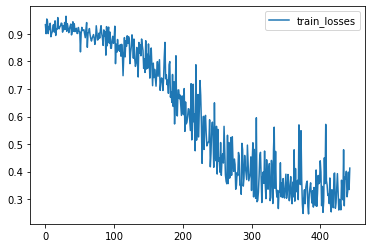

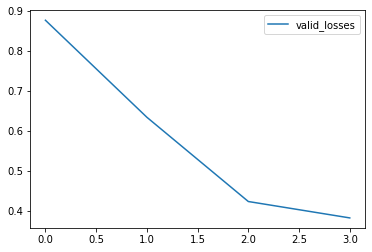

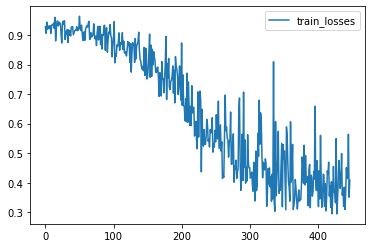

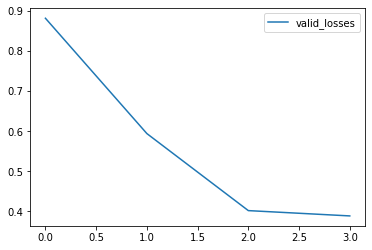

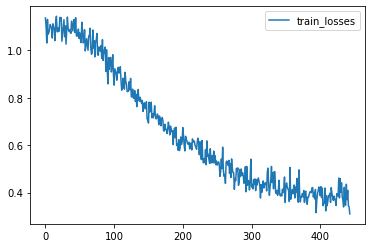

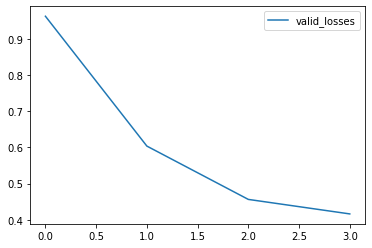

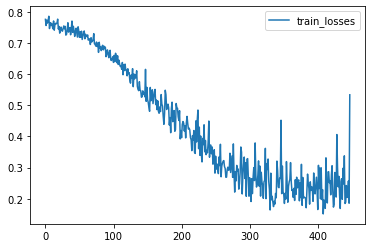

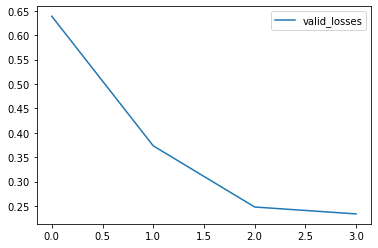

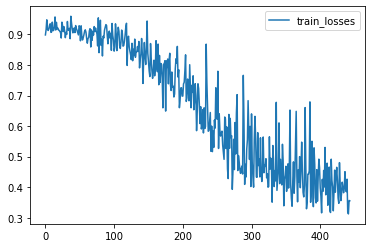

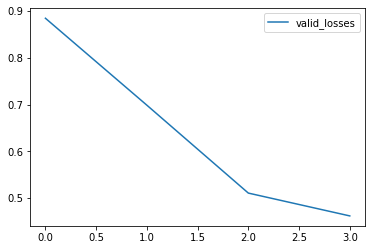

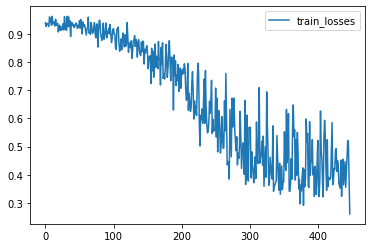

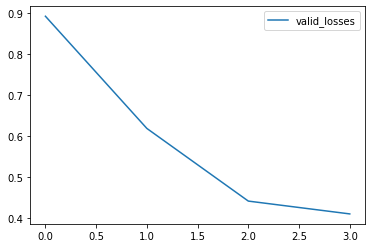

In [46]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)

In [47]:
print("Best trial")
trial_ = study.best_trial

trial_.values

Best trial


[0.49154266824632975]

In [48]:
trial_.params

{'loss': <function __main__.mixed_bce_dice_loss_fn(y_pred, y_true)>}

In [ ]:
train_split_and_move(fold_info, 0)

In [ ]:
train_split_and_move(fold_info, 1)

In [ ]:
train_split_and_move(fold_info, 2)

In [ ]:
train_split_and_move(fold_info, 3)

In [ ]:
!mv *.pth models